In [5]:
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

features_df = pd.read_csv("../dataset/processed/CEAS08_features.csv")
features_df[["subject_text", "body_text"]] = (
    features_df[["subject_text", "body_text"]].fillna("").astype(str)
)

text_features = ["subject_text", "body_text"]

numeric_features = [
    "sender_has_numbers", "sender_domain_length", "domain_mismatch",
    "subject_length", "subject_num_exclamations", "subject_num_question",
    "subject_max_repeated_punct", "subject_num_caps", "subject_has_spam_words",
    "body_length", "body_num_links", "body_num_exclamations",
    "body_num_question", "body_max_repeated_punct", "body_num_caps",
    "body_has_spam_words",
    "email_hour", "email_day_of_week"
]

text_transformer = TfidfVectorizer(
    lowercase=True,
    stop_words='english',
    max_features=5000
)

numeric_transformer = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf_subject", text_transformer, "subject_text"),
        ("tfidf_body", text_transformer, "body_text"),
        ("num", numeric_transformer, numeric_features),
    ]
)

In [6]:

pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("logreg", LogisticRegression(max_iter=2000))
])

X = features_df.drop(columns=["label"])
y = features_df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pipeline.fit(X_train, y_train)

,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('tfidf_subject', ...), ('tfidf_body', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
y_pred = pipeline.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=5))

Accuracy: 0.9948920955178138
              precision    recall  f1-score   support

           0    0.99565   0.99278   0.99421      3462
           1    0.99429   0.99657   0.99543      4369

    accuracy                        0.99489      7831
   macro avg    0.99497   0.99467   0.99482      7831
weighted avg    0.99489   0.99489   0.99489      7831



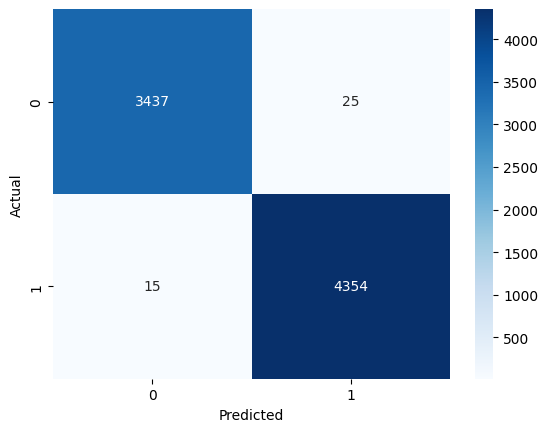

In [8]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [9]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(pipeline, X, y, cv=10)
scores.mean(), scores.std()

(np.float64(0.9909840559801815), np.float64(0.0071385517580003395))

In [10]:
import joblib
joblib.dump(pipeline, "../models/spam_detector.pkl")

['../models/spam_detector.pkl']

In [11]:
features_df["label"].value_counts()

label
1    21842
0    17312
Name: count, dtype: int64

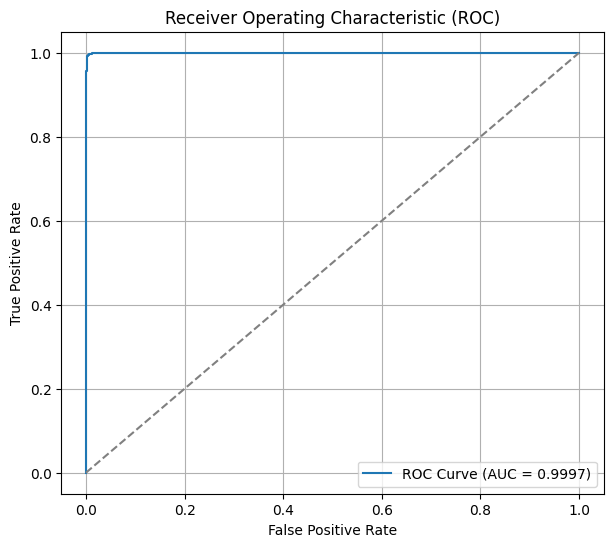

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_scores = pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # random model line

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend()
plt.grid(True)
plt.show()